# Imports

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import tensorflow as tf
import time
import pandas as pd
import ta
from tqdm import tqdm
import random
import pickle
from collections import deque
import time
import matplotlib.pyplot as plt

# Convert candlesticks to scaled inputs

In [2]:
def sample_to_x(sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]

                prev_sma21 = [candle.sma21 for candle in sample]
                #prev_sma50 = [candle.sma50 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]
                
                #dl = [candle.dl for candle in sample]
                #dh = [candle.dh for candle in sample]

                #dl_relative = [-(current_close - dl[o]) / dl[o] for o in range(seq_len)]
                #dh_relative = [-(current_close - dh[o]) / dh[o] for o in range(seq_len)]
                
                prev_sma21_relative = [-(current_close - prev_sma21[o]) / prev_sma21[o] for o in range(seq_len)]
                #prev_sma50_relative = [-(current_close - prev_sma50[o]) / prev_sma50[o] for o in range(seq_len)]
                prev_sma200_relative = [-(current_close - prev_sma200[o]) / prev_sma200[o] for o in range(seq_len)]

                prev_close_relative = [-(current_close - prev_close[o]) / prev_close[o] for o in range(seq_len)]
                prev_high_relative = [-(current_close - prev_high[o]) / prev_high[o] for o in range(seq_len)]
                prev_low_relative = [-(current_close - prev_low[o]) / prev_low[o] for o in range(seq_len)]

                
                #scale = 1 / (sample[-1].atr_value / sample[-1].c)
                maxv = max(prev_high_relative)
                minv = min(prev_low_relative)
                d = maxv-minv
                scale = 1 / d
                #scale = 1000 # scale price: 0.1% -> 1

                prev_sma21_relative_scaled = [i * scale for i in prev_sma21_relative]
                #prev_sma50_relative_scaled = [i * scale for i in prev_sma50_relative]
                prev_sma200_relative_scaled = [i * scale for i in prev_sma200_relative]

                prev_close_relative_scaled = [i * scale for i in prev_close_relative]
                prev_low_relative_scaled = [i * scale for i in prev_low_relative]
                prev_high_relative_scaled = [i * scale for i in prev_high_relative]

                #dl_rel_scaled = [i * scale for i in dl_relative]
                #dh_rel_scaled = [i * scale for i in dh_relative]
                
                prev_rsi_14 = [candle.rsi14 for candle in sample]


                x = []
                for o in range(len(prev_close)):
                    ts = []
                    ts.append(prev_close_relative_scaled[o])
                    ts.append(prev_high_relative_scaled[o])
                    ts.append(prev_low_relative_scaled[o])

                    ts.append(prev_sma21_relative_scaled[o])
                    #ts.append(prev_sma50_relative_scaled[o])
                    ts.append(prev_sma200_relative_scaled[o])
                    
                    #ts.append(dh_rel_scaled[o])
                    #ts.append(dl_rel_scaled[o])
                    
                    ts.append(prev_rsi_14[o])

                    x.append(ts)

                x = np.array(x)
                return x
        

# The environment class

In [3]:
def Load(file):
    f = open(file, "rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [4]:
seq_len = int(600)
comission = 20/100000
log_interval = 4*24 # environment logs daily returns
soft_reward_inc = 1.2

class candle_class:
    pass
  
order_value = 1000


class environment():

  def __init__(self):
    pass


  def _next_observation(self):
            candles = self.candles[self.current_step - seq_len + 1:self.current_step + 1]
            
            inference_data = sample_to_x(candles)
            
            return inference_data, np.array([self.position, self.current_win])

  
  def reset(self, first_reset = False):
    self.candles = None
    candles_files = os.listdir("candles")
    use_file = "candles/"+random.choice(candles_files)
    #print(use_file)
    self.candles = Load(use_file)
    
    
    
    self.current_step = 200+seq_len if first_reset == False else random.randint(200+seq_len,len(self.candles) - 1000)
    self.position = 0
    self.entry_price = 0
    self.win = 0
    self.current_win = 0
    self.startindex = self.current_step
    self.last_reward = 0
    self.reward_tr_given = 0
    self.reward_since_last_log = 0
    self.closed_trades_since_last_log = 0

    return self._next_observation()

  
  def close(self):
        self.win -= comission * order_value / 2
        self.position = 0
        self.win+=self.current_win - self.reward_tr_given
        self.reward_tr_given = 0
        self.current_win = 0
        self.closed_trades_since_last_log+=1
        
        
  def entry(self):
        self.entry_price = self.candles[self.current_step].c
        self.win -= comission * order_value / 2

  def step(self, action):
    
    if action == 0:
        if self.position != 0:
            self.close()
    
    if action == 1:
      #short
      if self.position == 1:
        self.close()

      if self.position == -1:
        pass
      else:
        self.position = -1
        self.entry()
        
    if action == 2:
      #long
      if self.position == -1:
        self.close()

      if self.position == 1:
        pass
      else:
        self.position = 1
        self.entry()
        
    self.current_step += 1
    if self.position != 0:
      current_price = self.candles[self.current_step].c
      entry = self.entry_price
      diff = (current_price - entry) / entry * order_value

      if self.position == 1:
        self.current_win = diff
      if self.position == -1:
        self.current_win = -diff

        
    diff = self.current_win - self.reward_tr_given
    reward_inc = diff / soft_reward_inc
    self.reward_tr_given += reward_inc
    self.win += reward_inc
    
    reward_raw = self.win# + self.current_win  # sparse reward enabled
    reward = reward_raw - self.last_reward
    self.last_reward = reward_raw
    reward = max(min(reward, 10), -10)
    
    
    done = self.current_step == len(self.candles) -1
    
    if (self.current_step - self.startindex) % log_interval == 0:
        log_reward = reward_raw - self.reward_since_last_log
        log_reward = max(min(log_reward, 200), -200)
        self.reward_since_last_log = reward_raw 
        file2 = open("logs/r2_log.txt", "a")  
        file2.write(str(log_reward))
        file2.write("\n")
        file2.close()
        
        
        file2 = open("logs/num_trades_per_day.txt", "a")  
        file2.write(str(self.closed_trades_since_last_log))
        file2.write("\n")
        file2.close()
        
        
        self.closed_trades_since_last_log = 0
    
    obs = self._next_observation()
    return obs, reward, done

# The agent class
Agent ist specialized for only this environment and not gym-compatible

In [5]:
class DQNAgent:
    def __init__(self, model,
                 n_actions,
                 memory_size = 10000, 
                 optimizer = tf.keras.optimizers.Adam(0.0005), 
                 gamma = 0.99,
                 batch_size =32,
                 name = "dqn1",
                 target_model_sync = 1000,
                 exploration = 0.01,
                ):
        self.exploration = exploration
        self.gamma = gamma
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.model = model
        self.name = name
        self.memory_size = memory_size
        self.optimizer = optimizer
        self.m1 = np.eye(self.n_actions, dtype="float32")
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model_sync = target_model_sync
   
        self.memory = deque(maxlen = self.memory_size)
        
 
    
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights())
      
    def load_weights(self):
        self.model.load_weights(self.name)
    def save_weights(self):
        self.model.save_weights(self.name, overwrite = True)
        
    @tf.function(jit_compile = False)
    def model_call(self, x):
        return tf.math.argmax(self.model(x), axis = 1)
    
    def select_actions(self, current_states, positions):
        
        if random.random() < self.exploration:
            num_inputs = len(positions)
            return tf.random.uniform(shape=[num_inputs], minval=0, maxval=3, dtype=tf.int32).numpy()
        
        return self.model_call([current_states, positions]).numpy()
        
    def observe_sasrt(self, state, action, next_state, reward, terminal):
        self.memory.append([state, action, reward, 1-int(terminal), next_state])
        
    @tf.function(jit_compile = False)
    def get_target_q(self, next_states, rewards, terminals):
        estimated_q_values_next = self.target_model(next_states)
        q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
        target_q_values = q_batch * self.gamma * terminals + rewards
        return target_q_values
    
        
    @tf.function(jit_compile = False) # jit not working for whatever reason
    def tstep(self, states, next_states, rewards, terminals, masks):
        target_q_values = self.get_target_q(next_states, rewards, terminals)
        
        with tf.GradientTape() as t:
            estimated_q_values = tf.math.reduce_sum(self.model(states, training=True) * masks, axis=1)
            loss = tf.keras.losses.mean_squared_error(target_q_values, estimated_q_values)
        
        gradient = t.gradient(loss, self.model.trainable_variables)
        
        if loss > 100:
            scale = 100 / loss
            
            gradients_scaled = []
            for i in gradient:
                gradients_scaled.append(i*scale)
            self.optimizer.apply_gradients(zip(gradients_scaled, self.model.trainable_variables))
        else:
            self.optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
            
        return loss, tf.reduce_mean(estimated_q_values)
    
    
    def update_parameters(self):
        sarts_batch = random.sample(self.memory, self.batch_size)
        
        states = [x[0] for x in sarts_batch]
        states_1 = np.array([x[0] for x in states], dtype="float32")
        states_2 = np.array([x[1] for x in states], dtype="float32")
        
        actions = [x[1] for x in sarts_batch]
        rewards = np.array([x[2] for x in sarts_batch], dtype="float32")
        terminals = np.array([x[3] for x in sarts_batch], dtype="float32")
        
        next_states = [x[4] for x in sarts_batch]
        next_states_1 = np.array([x[0] for x in next_states], dtype="float32")
        next_states_2 = np.array([x[1] for x in next_states], dtype="float32")
        
        masks = self.m1[actions]
        
        self.total_steps_trained+=1
        if self.total_steps_trained % self.target_model_sync == 0:
            self.copy_weights()
        
        return self.tstep([states_1, states_2], [next_states_1, next_states_2], rewards, terminals, masks)
    
    
    def train(self, num_steps, envs, log_interval = 1000, warmup = 0, train_steps_per_step = 1):
        
        self.total_steps_trained=-1
        num_envs = len(envs)
        states = [x.reset(True) for x in envs]
        
        current_episode_reward_sum = 0
        times= deque(maxlen=10)
        start_time = time.time()
        
        self.longs = 0
        self.shorts = 0

        self.total_rewards = []
        self.losses = [0]
        self.q_v = [0]
        
        def save_current_run():
            self.save_weights()
            file = open("logs/loss_log.txt", "a")  
            for loss in self.losses:
                        file.write(str(loss))
                        file.write("\n")
            file.close()

            file = open("logs/qv_log.txt", "a")  
            for qv in self.q_v:
                        file.write(str(qv))
                        file.write("\n")
            file.close()

            file = open("logs/rewards_log.txt", "a")  
            for total_reward in self.total_rewards:
                        file.write(str(total_reward))
                        file.write("\n")
            file.close()
            
    

            self.total_rewards = []
            self.losses = [0]
            self.q_v = [0]
        
        try:
            for i in range(num_steps):
                if i % log_interval == 0:
                    progbar = tf.keras.utils.Progbar(log_interval, interval=0.05, stateful_metrics = ["reward sum", "t", "l/s"])
                    self.longs = 0
                    self.shorts = 0


                states_1 = np.array([x[0] for x in states])
                states_2 = np.array([x[1] for x in states])
                actions = self.select_actions(states_1, states_2)
                for action in actions:
                    if action == 1:
                        self.shorts+=1
                    elif action == 2:
                        self.longs+=1

                sasrt_pairs = []
                for index in range(num_envs):
                    sasrt_pairs.append([states[index], actions[index]]+[x for x in envs[index].step(actions[index])])

                next_states = [x[2] for x in sasrt_pairs]

                reward = [x[3] for x in sasrt_pairs]
                current_episode_reward_sum += np.sum(reward)

                self.total_rewards.extend(reward)

                for index, o in enumerate(sasrt_pairs):
                    #print(o)
                    if o[4] == True:
                        next_states[index] = envs[index].reset()
                    self.observe_sasrt(o[0], o[1], o[2], o[3], o[4])

                states = next_states
                if i > warmup:
                    for _ in range(train_steps_per_step):
                        loss, q = self.update_parameters()
                        self.losses.append(loss.numpy())
                        self.q_v.append(q.numpy())
                else:
                    loss, q = 0, 0

                end_time = time.time()
                elapsed = (end_time - start_time) * 1000
                times.append(elapsed)
                start_time = end_time


                if (i+1) % log_interval == 0:
                    save_current_run()

                progbar.update(i%log_interval+1, values = 
                               [("loss", np.mean(self.losses[-train_steps_per_step:])),
                                ("mean q", np.mean(self.q_v[-train_steps_per_step:])),
                                ("rewards", np.mean(reward)),
                                ("reward sum", current_episode_reward_sum),
                                ("l/s", (self.longs - self.shorts) / (1+self.longs+self.shorts)),
                                ("t", np.mean(times))])
        
        except KeyboardInterrupt:
            print("\n\nbreak!")
        
        save_current_run()
            


# The Q-net

In [30]:
tf.keras.backend.clear_session()

inputs_1 = tf.keras.layers.Input(shape = (seq_len, 6))
inputs_pos = tf.keras.layers.Input(shape = (2))

x = inputs_1

x = tf.keras.layers.Dense(16,activation = "relu")(x)
x = tf.keras.layers.Dense(16,activation = "relu")(x)

x2 = tf.keras.layers.Conv1D(64, 3,activation="relu", padding="same")(x)
x = tf.keras.layers.Concatenate()([x2,x])

x = tf.keras.layers.Dense(32,activation = "relu")(x)

x2 = tf.keras.layers.Conv1D(512, 21,activation="relu", padding="same")(x)
x = tf.keras.layers.Concatenate()([x2,x])

x = tf.keras.layers.Dense(256,activation = "relu")(x)
x = tf.keras.layers.Dense(128,activation = "relu")(x)

x = tf.keras.layers.GRU(256, activation = "tanh", return_sequences = False)(x)

x = tf.keras.layers.Concatenate()([inputs_pos, x])

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)
        
outputs = tf.keras.layers.Dense(3, activation = "linear", use_bias=False, dtype="float32")(x)
model = tf.keras.Model([inputs_1,inputs_pos], outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 6)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 600, 16)      112         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 600, 16)      272         dense[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 600, 64)      3136        dense_1[0][0]                    
______________________________________________________________________________________________

# training the network

In [31]:
agent = DQNAgent(
    model = model, 
    n_actions = 3, 
    memory_size = 300000, 
    gamma=0.99,
    optimizer = tf.keras.optimizers.Adam(0.00025, clipvalue = 0.2), 
    batch_size = 128, 
    target_model_sync = 100,
    exploration = 0.005,
    name="deep_q_trading_l9")
#agent.load_weights()

In [32]:
num_parallel = 20
envs = [environment() for _ in range(num_parallel)]

In [25]:
n = int(20000)
agent.train(num_steps = n, envs = envs, warmup = n, log_interval = n, train_steps_per_step=1)

 6430/20000 [========>.....................] - ETA: 20:47 - loss: 0.0000e+00 - mean q: 0.0000e+00 - rewards: -0.1026 - reward sum: -13188.1204 - l/s: 0.8055 - t: 104.6201 ETA: 20:57 - loss: 0.0000e+00 - 

break!


In [26]:
len(agent.memory)

128600

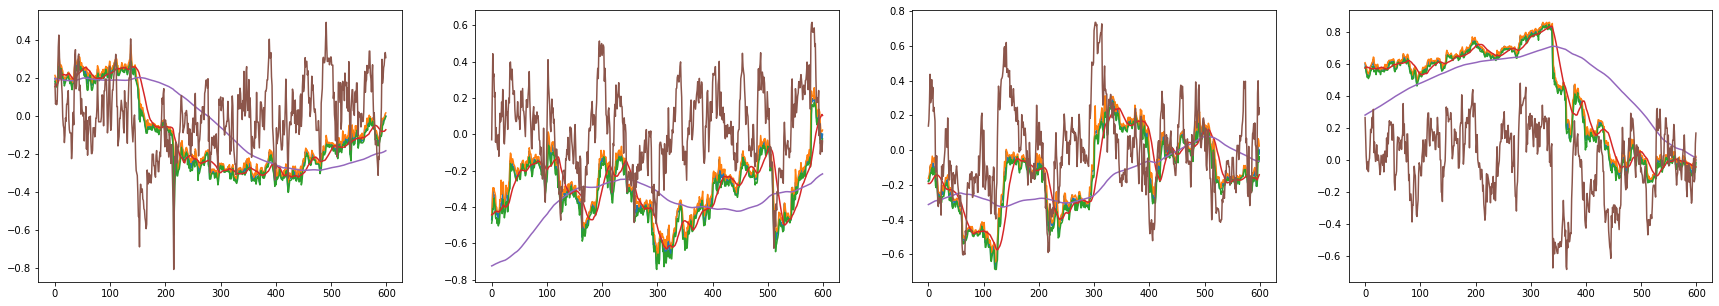

In [34]:
num_parallel = 4
envs = [environment() for _ in range(num_parallel)]

if True:    
    fig, ax = plt.subplots(1,num_parallel,figsize=(30,5))
    for o in range(num_parallel):
        x = envs[o].reset(True)[0]
        x_ = np.transpose(x)
        for i in x_:
            ax[o].plot(i) if num_parallel > 1 else ax.plot(i) 

In [ ]:
n = 100000000
agent.train(num_steps = n, envs = envs, warmup = 0, log_interval = 10000, train_steps_per_step=1)

 8306/10000 [=======================>......] - ETA: 12:47 - loss: 0.2581 - mean q: 0.4026 - rewards: -0.0028 - reward sum: -376.7655 - l/s: 0.9412 - t: 454.8630

In [ ]:
agent.save_weights()

In [ ]:
nx = [0,0,0]
for i in agent.memory:
    nx[i[1]]+=1
    
nx

In [15]:
#del m

In [16]:
#agent.batch_size = 128

In [29]:
m = agent.memory

In [33]:
for i in m:
    agent.memory.append(i)

# test


In [19]:
#for _ in tqdm(range(100)):
#    agent.update_parameters()

In [20]:
#for _ in tqdm(range(100)):
#    random.sample(agent.memory, agent.batch_size)

In [21]:
if True:
#for _ in tqdm(range(100)):
    sarts_batch = random.sample(agent.memory, 4)

    states = [x[0] for x in sarts_batch]
    states_1 = np.array([x[0] for x in states], dtype="float32")
    states_2 = np.array([x[1] for x in states], dtype="float32")

    actions = [x[1] for x in sarts_batch]
    rewards = np.array([x[2] for x in sarts_batch], dtype="float32")
    terminals = np.array([x[3] for x in sarts_batch], dtype="float32")

    next_states = [x[4] for x in sarts_batch]
    next_states_1 = np.array([x[0] for x in next_states], dtype="float32")
    next_states_2 = np.array([x[1] for x in next_states], dtype="float32")

    print(actions)
    masks = agent.m1[actions]

    next_states = [next_states_1, next_states_2]


    estimated_q_values_next = agent.target_model(next_states)
    q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
    target_q_values = q_batch * agent.gamma * terminals + rewards


    states = [states_1, states_2]
    
    
    with tf.GradientTape() as t:
                estimated_q_values = tf.math.reduce_sum(agent.model(states, training=True) * masks, axis=1)
                loss = tf.keras.losses.mean_squared_error(target_q_values, estimated_q_values)

    scale = tf.minimum(tf.constant(1, dtype="float32"), 1 / loss)
    gradient = t.gradient(loss, agent.model.trainable_variables)
    gradients_scaled = []
    for i in gradient:
        gradients_scaled.append(i*scale)
    agent.optimizer.apply_gradients(zip(gradients_scaled, agent.model.trainable_variables))
    print(loss)
    print(target_q_values)
    print(estimated_q_values)
    print(rewards)

[0, 0, 2, 0]
tf.Tensor(0.010530681, shape=(), dtype=float32)
tf.Tensor([0.01736852 0.02787215 0.14484958 0.02131513], shape=(4,), dtype=float32)
tf.Tensor([ 0.01371138  0.01665317 -0.05986428  0.03001668], shape=(4,), dtype=float32)
[0.         0.         0.12021491 0.        ]
